In [1]:
import numpy as np
import pandas as pd

import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans # KMeans clustering 
from sklearn.metrics import silhouette_score

In [2]:
print(pd.__version__)

1.4.0


# Load Data

In [3]:
FILE = "Garcinia kola\Morphology\Morphology_merge_dtr.xlsx"
SHEET = "Morphology_merge"
data_raw = pd.read_excel(FILE, sheet_name = SHEET, header = [0])

data_raw.shape

(2089, 35)

In [4]:
# Select Targets and Train
study_area = data_raw["Region"]
tree_id = data_raw["Tree ID"]
tree_fruit_id = data_raw["Tree ID"].astype(str) + '_'+ data_raw["Fruit ID"].astype(str)


COL_NAMES = ['GPS',
             'Elevation (m a.s.l.)', 
             'Age of tree (y)', 
             'Topography', 'Surrounding',
             'DBH (cm)', 'Crown diameter (m)', 'Crown shape', 'Crown rating',
             'Tree height (m)', 'Trunk height (m)', 
             'Condition', 
             'Branching', 'Trunk shape', 'Fruit Weight (g)', 'Fruit Diameter (cm)',
             'Fruit Length (cm)', 'Fruit No of seeds', 'Fruit Seed mass (g)',
             'Seed mass ratio %', 'Fruit Shape', 
    #         #'Fruit Shape*', 
             'Fruit Colour',
             'Seed Weight (g)', 'Seed Length (cm)', 'Seed Width (cm)', 'Seed Shape',
#              'Seed Shape *',
             'Seed Colour']

data = data_raw[COL_NAMES].copy()

# Region assignments

In [5]:
#add_missing_area
def add_area(x):
    if x == "CABD":
        x = "Akok"
    elif x == "CNAT":
        x = "Nkelikok"
    elif x == "SEJS":
        x = "Ebolowa"
    else:
        x = x
    
    return x
    
    
study_area = study_area.apply(lambda x: add_area(x))


# Add Region south and central
area2region = {}
area2region["Akok"] = "central"
area2region["Bokito"] = "central" #
area2region["Lekiasi"] = "central"
area2region["Makak"] = "central"
area2region["Nkelikok"] = "central"

area2region["Ebolowa"] = "south"
area2region["Kye-Ossi "] = "south"
area2region["Sangmelima"] = "south"
area2region["Zoételé"] = "south"

region = study_area.apply(lambda x: area2region[x])

# Missing Values Overview

In [6]:
data.isnull().sum()

GPS                      0
Elevation (m a.s.l.)     0
Age of tree (y)         37
Topography               0
Surrounding              0
DBH (cm)                 0
Crown diameter (m)       0
Crown shape              0
Crown rating             0
Tree height (m)          0
Trunk height (m)         0
Condition                0
Branching                0
Trunk shape              0
Fruit Weight (g)         0
Fruit Diameter (cm)     88
Fruit Length (cm)       88
Fruit No of seeds        0
Fruit Seed mass (g)      0
Seed mass ratio %        0
Fruit Shape             88
Fruit Colour            88
Seed Weight (g)          0
Seed Length (cm)         0
Seed Width (cm)          1
Seed Shape               0
Seed Colour              0
dtype: int64

# Feature Engineering
Goal is to embedd all value in a numerical space.

In [7]:
def get_type_and_NA(col):
    print("Column: {}".format(col))
    print("  Data Type: {}".format(data[col].dtypes))
    print("  Missing Values: {}".format(data[col].isnull().sum()))

In [8]:
data.dtypes

GPS                      object
Elevation (m a.s.l.)      int64
Age of tree (y)         float64
Topography               object
Surrounding              object
DBH (cm)                float64
Crown diameter (m)      float64
Crown shape              object
Crown rating             object
Tree height (m)         float64
Trunk height (m)        float64
Condition                object
Branching                object
Trunk shape               int64
Fruit Weight (g)        float64
Fruit Diameter (cm)     float64
Fruit Length (cm)        object
Fruit No of seeds         int64
Fruit Seed mass (g)     float64
Seed mass ratio %       float64
Fruit Shape              object
Fruit Colour             object
Seed Weight (g)         float64
Seed Length (cm)        float64
Seed Width (cm)         float64
Seed Shape               object
Seed Colour              object
dtype: object

In [9]:
# Length should be float type
data.loc[data["Fruit Length (cm)"] == "6,1", "Fruit Length (cm)"] = "6.1"
data["Fruit Length (cm)"] = data["Fruit Length (cm)"].astype("float64") 

## Object Features

In [10]:
col_names_obj = data.columns[data.dtypes == "object"].to_list()
col_names_obj

['GPS',
 'Topography',
 'Surrounding',
 'Crown shape',
 'Crown rating',
 'Condition',
 'Branching',
 'Fruit Shape',
 'Fruit Colour',
 'Seed Shape',
 'Seed Colour']

**GPS**
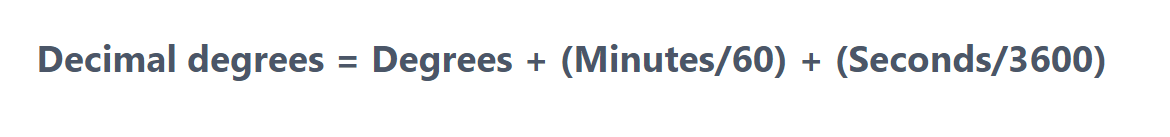

In [11]:
get_type_and_NA("GPS")

Column: GPS
  Data Type: object
  Missing Values: 0


In [12]:
# GPA
def dms2dd(dms):
    
    x = dms.split()

    lat_degree = float(x[1])
    lat_min = float(x[2])
    long_degree = float(x[4])
    long_min = float(x[5])

    lat_dec = lat_degree + np.divide(lat_min,60) 
    lon_dec = long_degree + np.divide(long_min,60) 
    
    return [lat_dec, lon_dec]

# test
x = data["GPS"][0]
dms2dd(x)

[3.5498833333333333, 11.8615]

In [13]:
# Bug fix: Space errror for index 556 - 556
data.loc[list(data["GPS"].apply(lambda x: len(x.split())) != 6), ["GPS"]] = "N 03 46.612 E 11 13.471"

In [14]:
# Convert 
lat_lon = data["GPS"].apply(lambda x: dms2dd(x))
data_train = pd.DataFrame()
# data_train["lat"] = [i for i,_ in lat_lon]
# data_train["long"] = [j for _,j in lat_lon]

**Topography**

In [15]:
get_type_and_NA("Topography")

Column: Topography
  Data Type: object
  Missing Values: 0


In [16]:
data["Topography"].value_counts()

almost flat          1133
gently undulating     445
undulating            262
hilly                 139
flat                  110
Name: Topography, dtype: int64

In [17]:
topo2num = {}

topo2num["flat"] = 1
topo2num["almost flat"] = 2
topo2num["gently undulating"] = 3
topo2num["undulating"] = 4
topo2num["hilly"] = 5
topo2num

{'flat': 1,
 'almost flat': 2,
 'gently undulating': 3,
 'undulating': 4,
 'hilly': 5}

In [18]:
# Replace values
data_train["Topography"] = data["Topography"].apply(lambda x: topo2num[x])

**Condition**

In [19]:
get_type_and_NA("Condition")

Column: Condition
  Data Type: object
  Missing Values: 0


In [20]:
data["Condition"].value_counts()

healthy             914
mature vigorous     734
cropping poorly     398
dying (termites)     29
non vigorous         14
Name: Condition, dtype: int64

In [21]:
condition2num = {}

condition2num["healthy"] = 1
condition2num["mature vigorous"] = 1
condition2num["non vigorous"] = 2
condition2num["cropping poorly"] = 2
condition2num["dying (termites)"] = 3
condition2num

{'healthy': 1,
 'mature vigorous': 1,
 'non vigorous': 2,
 'cropping poorly': 2,
 'dying (termites)': 3}

In [22]:
# Replace values
data_train["Condition"] = data["Condition"].apply(lambda x: condition2num[x])

**For the rest object columns take the term/word frequency as numerical representation**

In [23]:
col_names_obj_2 = [c for c in col_names_obj if not c in ["GPS", "Condition", "Topography"]]

In [24]:
# Check for missing values
data.loc[:,col_names_obj_2].isna().sum()

Surrounding      0
Crown shape      0
Crown rating     0
Branching        0
Fruit Shape     88
Fruit Colour    88
Seed Shape       0
Seed Colour      0
dtype: int64

In [25]:
def word2tf(col):
    #count term frequency
    word_counts = dict(data[col].value_counts())
    #Nan case
    word_counts[0] = np.nan
    
    # Replace terms with counts 
    tmp = data[col].fillna(0).apply(lambda x: word_counts[x])
    # Fill Nan with mean
    tmp = tmp.fillna(tmp.mean())
    
    return tmp

for col in col_names_obj_2:
    data_train[col] = word2tf(col)

        DONE with object variables!

## Numerical Features

In [26]:
col_names_num = data.columns[data.dtypes != "object"].to_list()
col_names_num

['Elevation (m a.s.l.)',
 'Age of tree (y)',
 'DBH (cm)',
 'Crown diameter (m)',
 'Tree height (m)',
 'Trunk height (m)',
 'Trunk shape',
 'Fruit Weight (g)',
 'Fruit Diameter (cm)',
 'Fruit Length (cm)',
 'Fruit No of seeds',
 'Fruit Seed mass (g)',
 'Seed mass ratio %',
 'Seed Weight (g)',
 'Seed Length (cm)',
 'Seed Width (cm)']

In [27]:
# Missing Values
data.loc[:,col_names_num].isna().sum()

Elevation (m a.s.l.)     0
Age of tree (y)         37
DBH (cm)                 0
Crown diameter (m)       0
Tree height (m)          0
Trunk height (m)         0
Trunk shape              0
Fruit Weight (g)         0
Fruit Diameter (cm)     88
Fruit Length (cm)       88
Fruit No of seeds        0
Fruit Seed mass (g)      0
Seed mass ratio %        0
Seed Weight (g)          0
Seed Length (cm)         0
Seed Width (cm)          1
dtype: int64

In [28]:
x = data.loc[:,col_names_num].isna().sum()
col_names_num_with_nan = x[x>0].index.to_list()
col_names_num_with_nan

def replace_with_mean(col):
    return data[col].fillna(data[col].mean())

for col in col_names_num_with_nan:
    data_train[col] = replace_with_mean(col)

**Add all numerical features without missing values**

In [29]:
col_names_num_without_nan = [c for c in col_names_num if not c in col_names_num_with_nan]
col_names_num_without_nan

['Elevation (m a.s.l.)',
 'DBH (cm)',
 'Crown diameter (m)',
 'Tree height (m)',
 'Trunk height (m)',
 'Trunk shape',
 'Fruit Weight (g)',
 'Fruit No of seeds',
 'Fruit Seed mass (g)',
 'Seed mass ratio %',
 'Seed Weight (g)',
 'Seed Length (cm)']

In [30]:
# Add to data_train
data_train[col_names_num_without_nan] = data[col_names_num_without_nan]

**Result Train Data**

In [31]:
data_train.dtypes

Topography                int64
Condition                 int64
Surrounding               int64
Crown shape               int64
Crown rating              int64
Branching                 int64
Fruit Shape             float64
Fruit Colour            float64
Seed Shape                int64
Seed Colour               int64
Age of tree (y)         float64
Fruit Diameter (cm)     float64
Fruit Length (cm)       float64
Seed Width (cm)         float64
Elevation (m a.s.l.)      int64
DBH (cm)                float64
Crown diameter (m)      float64
Tree height (m)         float64
Trunk height (m)        float64
Trunk shape               int64
Fruit Weight (g)        float64
Fruit No of seeds         int64
Fruit Seed mass (g)     float64
Seed mass ratio %       float64
Seed Weight (g)         float64
Seed Length (cm)        float64
dtype: object

## Standardize Data

In [32]:
X = data_train.values[:]
X_std = StandardScaler().fit_transform(X)

# PCA

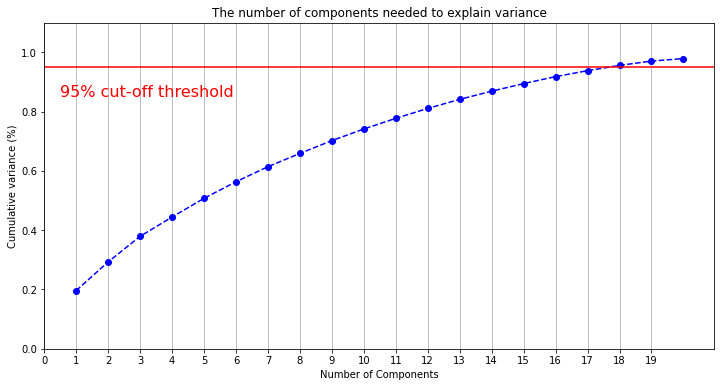

In [53]:
c = 20

pca = PCA(n_components=c)
pca.fit(X_std)
X_10d = pca.transform(X_std)


plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, c + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, c, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In this case, to get 95% of variance explained we need 18 principal components.

In [54]:
pca = PCA(n_components=18)
pca.fit(X_std)
X_PCA = pca.transform(X_std)

In [86]:
# Target DF
df = pd.DataFrame()
df["1d"] = X_PCA[:,0]
df["2d"] = X_PCA[:,1]
df["Study Area"] = study_area.astype(str)
df["Tree ID"] = tree_id.astype(str)
df["Tree Fruit ID"] = tree_fruit_id
df["Region"] = region

In [87]:
fig = px.scatter(df, x="1d", y="2d", color="Study Area", title = "PCA")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

In [89]:
fig = px.scatter(df, x="1d", y="2d", color="Region", title = "PCA", hover_name = "Study Area")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

In [93]:
# # Target Tree ID
# fig = px.scatter(df, x="1d", y="2d", color="Tree ID")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
# fig.show()

Insights:

- Tree 1, 2, 3 providing the most seeds in the sample are not well seperable
- Tree  4, 5, 6, 8 providing less seeds each, however there are more distinguishable against each other but mixing with 1,2 and 3.
- Seeds from tree 8 are all in no proximity to 4, 5 or 6

### K means on PCA


In [90]:
kmeans = KMeans(n_clusters=38)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_PCA)
df["Kmeans Cluster"] = X_clustered.astype("str")


fig = px.scatter(df, x="1d", y="2d", color="Kmeans Cluster", title = "PCA")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

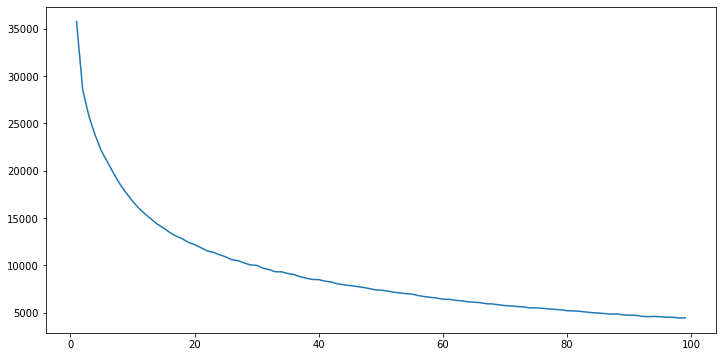

In [40]:
# Finding k
dist_point_from_cluster_center = []
K = range(1,100)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_PCA)
    dist_point_from_cluster_center.append(kmeans.inertia_)

plt.plot(K, dist_point_from_cluster_center)

Nuber of Clusters very high -> the data is very similar across the regions.

### DBSCAN & PCA

In [94]:
db_cluster = DBSCAN(eps = 3, min_samples=5).fit_predict(X_PCA)
df["dbscsan cluster"] = db_cluster.astype("str")


fig = px.scatter(df, x="1d", y="2d", color="dbscsan cluster", title = "t-SNE")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

# py.plot(fig, filename = "t-sne and kmeans.html")

# T-SNE

In [61]:
# Invoking the t-SNE method
tsne = TSNE()
tsne_results = tsne.fit_transform(X_std) 

In [95]:
# Target DF
df = pd.DataFrame()
df["1d"] = tsne_results[:,0]
df["2d"] = tsne_results[:,1]
df["Study Area"] = study_area.astype(str)
df["Tree ID"] = tree_id.astype(str)
df["Tree Fruit ID"] = tree_fruit_id
df["Region"] = region

In [96]:
region_dic = {}

region_dic["central"] = 1
region_dic["south"] = 2

df["Region_ID"] = region.apply(lambda x: region_dic[x])

In [97]:
fig = px.scatter(df, x="1d", y="2d", color="Region", title = "t-SNE")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

# py.plot(fig, filename = "t-sne and region.html")

't-sne and region.html'

In [100]:
fig = px.scatter(df, x="1d", y="2d", color="Study Area", title = "t-SNE")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

# py.plot(fig, filename = "t-sne and study area.html")

In [65]:
# fig = px.scatter(df, x="1d", y="2d", color="Tree ID", title = "t-SNE")
# # fig.update_layout(
# #     title = "PCA",
# #     paper_bgcolor="LightSteelBlue"
# # )
# fig.show()

# #py.plot(fig, filename = "t-sne and region.html")

### t-SNE & KMeans

In [71]:
kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(tsne_results)
df["Kmeans Cluster"] = X_clustered.astype("str")


fig = px.scatter(df, x="1d", y="2d", color="Kmeans Cluster", title = "t-SNE")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

# py.plot(fig, filename = "t-sne and kmeans.html")

print("Silhouette Coefficient: %0.3f" % silhouette_score(tsne_results, X_clustered))

Silhouette Coefficient: 0.384


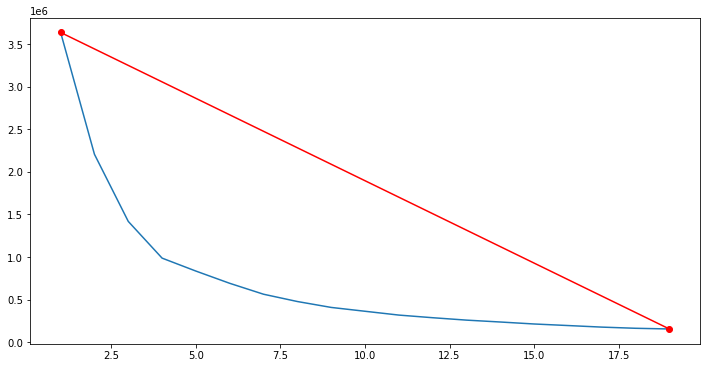

In [67]:
# Finding k
dist_point_from_cluster_center = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsne_results)
    dist_point_from_cluster_center.append(kmeans.inertia_)

plt.plot(K, dist_point_from_cluster_center)
plt.plot( [K[0], K[18]], [dist_point_from_cluster_center[0], 
                          dist_point_from_cluster_center[18]], "ro-" )

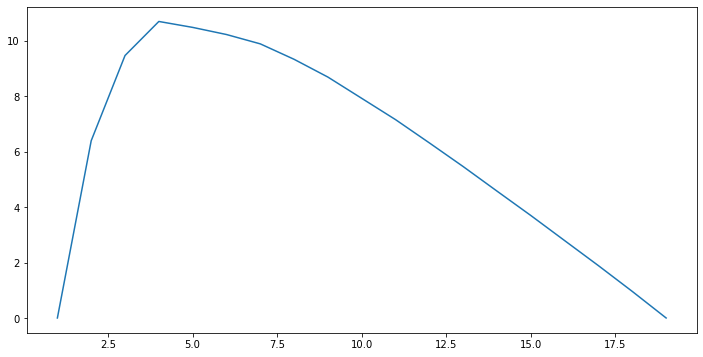

In [68]:
import math
def calc_distance(x1,y1, a,b,c):
    d = abs ((a * x1 + b * y1 + c)) / np.sqrt(a*a + b*b)
    return d

a = dist_point_from_cluster_center[0] - dist_point_from_cluster_center[18]
b = K[18] - K[0]
c1 = K[0] * dist_point_from_cluster_center[18]
c2 = K[18] * dist_point_from_cluster_center[0]
c = c1 - c2

distances = []
for k in K:
    distances.append(calc_distance(K[k-1], dist_point_from_cluster_center[k-1], a,b,c))
    
plt.plot(K, distances)

In [69]:
# max(distances)
distances.index(max(distances))

3

### t-SNE & DBSCAN

In [81]:
region_dic = {}

region_dic["central"] = 0.2
region_dic["south"] = 1

df["Region_ID"] = region.apply(lambda x: region_dic[x])

In [99]:
db_cluster = DBSCAN(eps = 3, min_samples= 10).fit_predict(tsne_results)
df["dbscsan cluster"] = db_cluster.astype("str")

print("Silhouette Coefficient: %0.3f" % silhouette_score(tsne_results, db_cluster))

fig = px.scatter(df, x="1d", y="2d", color="dbscsan cluster", title = "t-SNE", hover_name = "Region", size = "Region_ID")
# fig.update_layout(
#     title = "PCA",
#     paper_bgcolor="LightSteelBlue"
# )
fig.show()

# py.plot(fig, filename = "t-sne and dbscsn.html")

Silhouette Coefficient: 0.626


't-sne and dbscsn.html'